In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import pickle
import os

%matplotlib notebook

In [2]:
fol='/home/alessio/k-nokick'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> HTML
1 -> IMPORTANTS
2 -> csv
3 -> d-experiments_smooth01_0000
4 -> d-experiments_smooth10_0000
5 -> d-experiments_smooth50_0000
6 -> d-experiments_smooth50_0001
7 -> y-IR_140_nac0_0000
8 -> y-IR_140_nac10_0000



In [4]:
subfolder = subfolders[4]
subfolder

'd-experiments_smooth10_0000'

In [5]:
a = os.path.join(fol,subfolder)
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']

if filesList == []:
    warning('The folder has not GaussianXXXX.h5 files')

outh5 = os.path.join(a,'allInput.h5')
name_momentum_file = os.path.join(a,'momentum.csv')


if os.path.isfile(name_momentum_file):
#if False:
    qp.good('Momentum file exists !')
    print('if you want to remove it:\n\nrm {}'.format(name_momentum_file))
    dictio = qp.readWholeH5toDict(outh5)
    phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
    dphi,dgam,dthe = dictio['dphi'],dictio['dgam'],dictio['dthe']
    calculate_momentum = False
else:
    calculate_momentum = True
    dictio = qp.readWholeH5toDict(outh5)
    phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
    dphi,dgam,dthe = dictio['dphi'],dictio['dgam'],dictio['dthe']
    print(dictio.keys())
    zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
    #vmaxV = abs2(zeroWF).max()
    phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
    filesN = len(filesList)
    allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
    alltime = np.empty((filesN))
    # I need population to normalize momentum
    allPopul = np.empty((filesN,nstates))
    lastV = len(filesList)-1

    # 
    #for i,fn in enumerate(filesList):
    for i,fn in qp.log_progress(enumerate(filesList),every=1,size=(len(filesList))):
        fnn = os.path.join(a,fn)
        wf_here = qp.retrieve_hdf5_data(fnn,'WF')
        allwf[i] = wf_here
        alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]
        for s in range(nstates):
            allPopul[i,s] = np.linalg.norm(wf_here[:,:,:,s])**2

    outfn = os.path.join(a,'output')
    outfnP = os.path.join(a,'outputPopul')

dict_keys(['nacCube', 'natoms', 'phiL', 'dthe', 'gams', 'phis', 'kinCube', 'pulseZ', 'absorb', 'dgam', 'gamL', 'nstates', 'pulseY', 'theL', 'dphi', 'Nac_multiplier', 'thes', 'fullTime', 'vmax_value', 'dt', 'outFol', 'dipCube', 'kind', 'potCube', 'initialTotal', 'pulseX'])


A Jupyter Widget

In [6]:
if calculate_momentum:
    momentum_p = np.empty((filesN,nstates+1))
    momentum_g = np.empty((filesN,nstates+1))
    momentum_t = np.empty((filesN,nstates+1))
    max_p = np.empty((filesN,nstates+1))
    max_g = np.empty((filesN,nstates+1))
    max_t = np.empty((filesN,nstates+1))

    for f in qp.log_progress(range(filesN),every=1,size=(filesN)):

        GRID = allwf[f,:,:,:,:]
        momp,momg,momt = qp.CextractMomentum3d(GRID,dictio) # those are the momentum CUBEs

        for s in range(nstates+1):
            if s != 8:
                # The momentum is normalized by the amount of population in a single state
                momentum_p[f,s] = np.real(np.vdot(GRID[:,:,:,s],momp[:,:,:,s]))/allPopul[f,s]
                momentum_g[f,s] = np.real(np.vdot(GRID[:,:,:,s],momg[:,:,:,s]))/allPopul[f,s]
                momentum_t[f,s] = np.real(np.vdot(GRID[:,:,:,s],momt[:,:,:,s]))/allPopul[f,s]
                max_p[f,s] = np.amax(qp.abs2(momp[:,:,:,s]))
                max_g[f,s] = np.amax(qp.abs2(momg[:,:,:,s]))
                max_t[f,s] = np.amax(qp.abs2(momt[:,:,:,s]))
            else:
                momentum_p[f,s] = np.real(np.vdot(GRID,momp))
                momentum_g[f,s] = np.real(np.vdot(GRID,momg))
                momentum_t[f,s] = np.real(np.vdot(GRID,momt))
                max_p[f,s] = np.amax(qp.abs2(momp))
                max_g[f,s] = np.amax(qp.abs2(momg))
                max_t[f,s] = np.amax(qp.abs2(momt))

A Jupyter Widget

/home/alessio/config/miniconda/envs/quantumpropagator/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/alessio/config/miniconda/envs/quantumpropagator/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/alessio/config/miniconda/envs/quantumpropagator/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
if calculate_momentum:
    def nameMe(stri):
        return ['{}_{}'.format(stri,x) for x in range(nstates)] + ['{}_{}'.format(stri,'Tot')]

    # nameMe('lol')

    df0 = pd.DataFrame(data=alltime, columns=['fs'])
    df1 = pd.DataFrame(data=momentum_p, columns=nameMe('Momentum-phi'))
    df2 = pd.DataFrame(data=momentum_g, columns=nameMe('Momentum-gam'))
    df3 = pd.DataFrame(data=momentum_t, columns=nameMe('Momentum-the'))
    df4 = pd.DataFrame(data=max_p, columns=nameMe('Max-phi'))
    df5 = pd.DataFrame(data=max_g, columns=nameMe('Max-gam'))
    df6 = pd.DataFrame(data=max_t, columns=nameMe('Max-the'))

    df = pd.concat([df0,df1,df2,df3,df4,df5,df6],axis=1)

    name_momentum_file = os.path.join(a,'momentum.csv')
    df.to_csv(name_momentum_file)
else:
    df = pd.read_csv(name_momentum_file)

-1256.63706144 -1172.63843648 1610.73825503


<IPython.core.display.Javascript object>


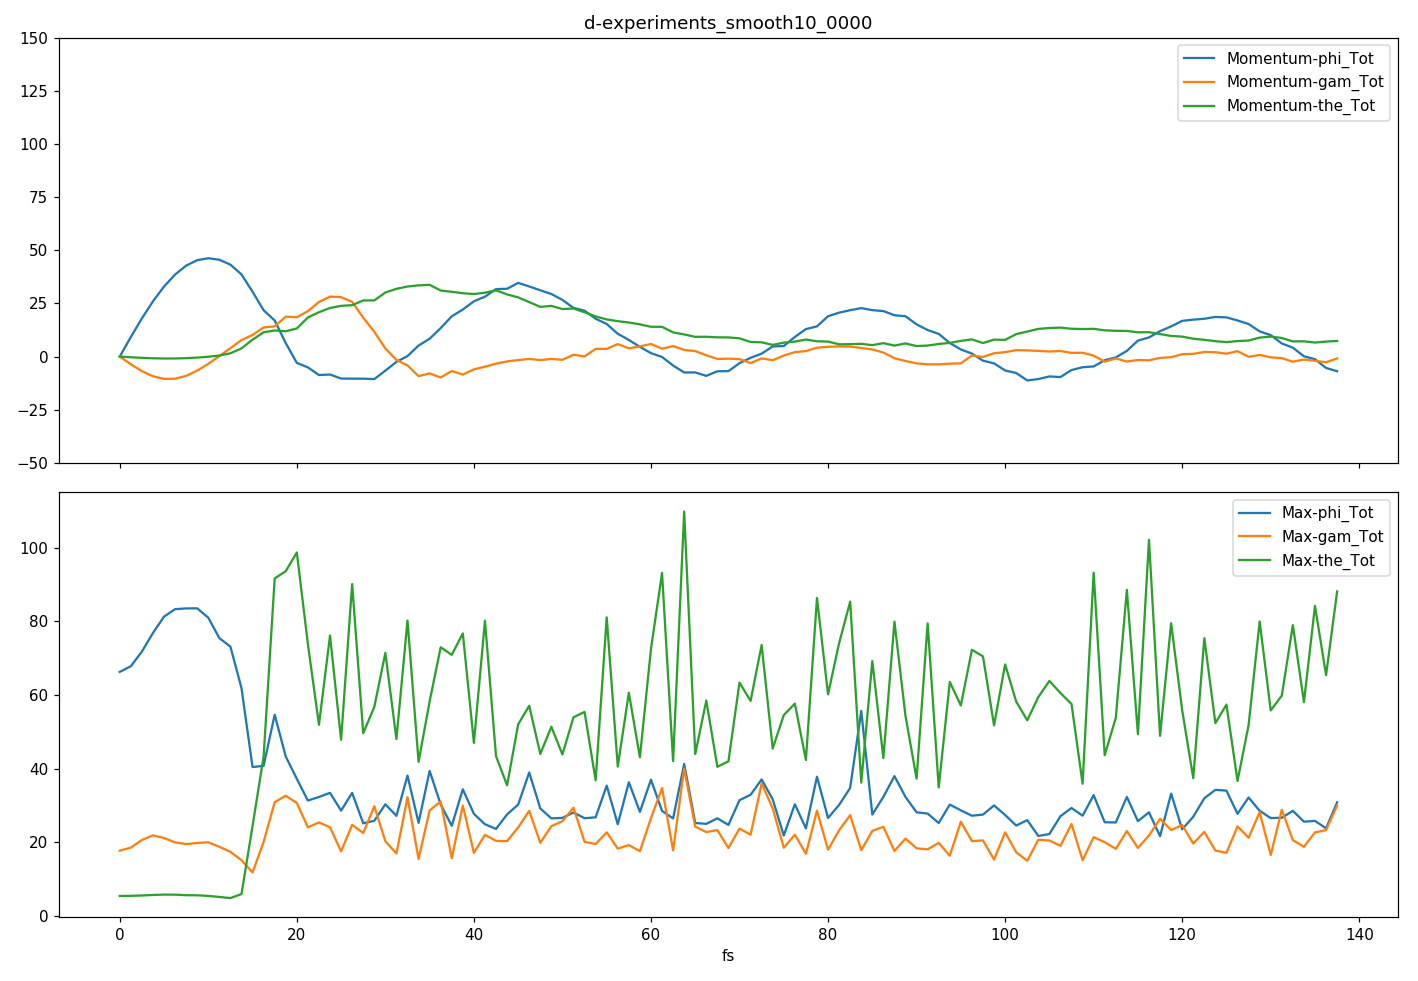

In [8]:
def gg(n):
    return (2*np.pi)/n

print(gg(dphi),gg(dgam),gg(dthe))
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(13,9),sharex=True)

ax0.plot(df['fs'],df['Momentum-phi_Tot'], label=('Momentum-phi_Tot'))
ax0.plot(df['fs'],df['Momentum-gam_Tot'], label=('Momentum-gam_Tot'))
ax0.plot(df['fs'],df['Momentum-the_Tot'], label=('Momentum-the_Tot'))
ax0.set_ylim(-50,150)
ax0.set_title('{}'.format(subfolder))
ax0.legend()

ax1.plot(df['fs'],df['Max-phi_Tot'], label=('Max-phi_Tot'))
ax1.plot(df['fs'],df['Max-gam_Tot'], label=('Max-gam_Tot'))
ax1.plot(df['fs'],df['Max-the_Tot'], label=('Max-the_Tot'))
ax1.set_xlabel('fs')
ax1.legend()

fig.tight_layout();


In [27]:
df

,fs,Momentum-phi_0,Momentum-phi_1,Momentum-phi_2,Momentum-phi_3,Momentum-phi_4,Momentum-phi_5,Momentum-phi_6,Momentum-phi_7,Momentum-phi_Tot,...,Max-gam_Tot,Max-the_0,Max-the_1,Max-the_2,Max-the_3,Max-the_4,Max-the_5,Max-the_6,Max-the_7,Max-the_Tot
0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,17.776906,5.474280,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.474280
1,1.250000,9.167955,-6.391985,34.467086,9.883742,11.293490,29.624617,16.336208,15.820818,9.167818,...,18.609263,5.515158,8.893275e-07,0.000116,0.000112,0.000015,0.000403,0.005479,0.002107,5.515158
2,2.500000,17.945736,7.455246,59.263091,-19.531772,4.293909,34.731340,-17.031993,-7.134737,17.944142,...,20.667125,5.619381,8.455926e-07,0.000207,0.000281,0.000027,0.001678,0.016929,0.005143,5.619381
3,3.750000,25.974370,28.875222,76.297822,-27.297631,6.424428,34.173196,-5.014172,3.195879,25.969227,...,21.921271,5.754877,1.322862e-06,0.000149,0.000116,0.000038,0.001753,0.028593,0.011605,5.754877
4,4.999999,32.948828,29.163244,82.113494,-17.661791,36.957739,32.476908,1.858285,4.594981,32.937167,...,21.209595,5.857422,5.108888e-06,0.000156,0.000129,0.000050,0.003276,0.045891,0.019280,5.857422
5,6.249999,38.624818,35.101563,80.492676,2.997880,30.138296,27.808838,5.921568,13.862100,38.603467,...,20.010361,5.835310,4.073686e-05,0.000182,0.000175,0.000099,0.004774,0.085881,0.029758,5.835310
6,7.499999,42.818538,39.374829,96.854708,35.298855,72.206145,18.809856,1.910581,13.480753,42.784065,...,19.558785,5.697583,2.511898e-04,0.000337,0.000337,0.000129,0.010519,0.136696,0.047678,5.697583
7,8.749999,45.399630,42.737514,108.814315,54.400159,67.391571,18.169649,3.456307,34.964467,45.350890,...,19.871353,5.662306,1.180651e-03,0.002322,0.002237,0.000249,0.007593,0.174543,0.060679,5.662306
8,9.999999,46.323987,43.942649,71.134337,46.314297,75.193406,23.826594,5.230378,31.927066,46.255864,...,20.040282,5.497293,8.441737e-03,0.025162,0.021411,0.000472,0.032499,0.393003,0.148133,5.497293
9,11.249999,45.634928,42.045437,58.298392,43.719572,71.531117,20.847436,7.257832,44.866508,45.542753,...,18.832813,5.215908,1.079300e-01,0.246918,0.168840,0.004987,0.052055,0.475800,0.199855,5.215908


'Momentum-phi_2'

<IPython.core.display.Javascript object>


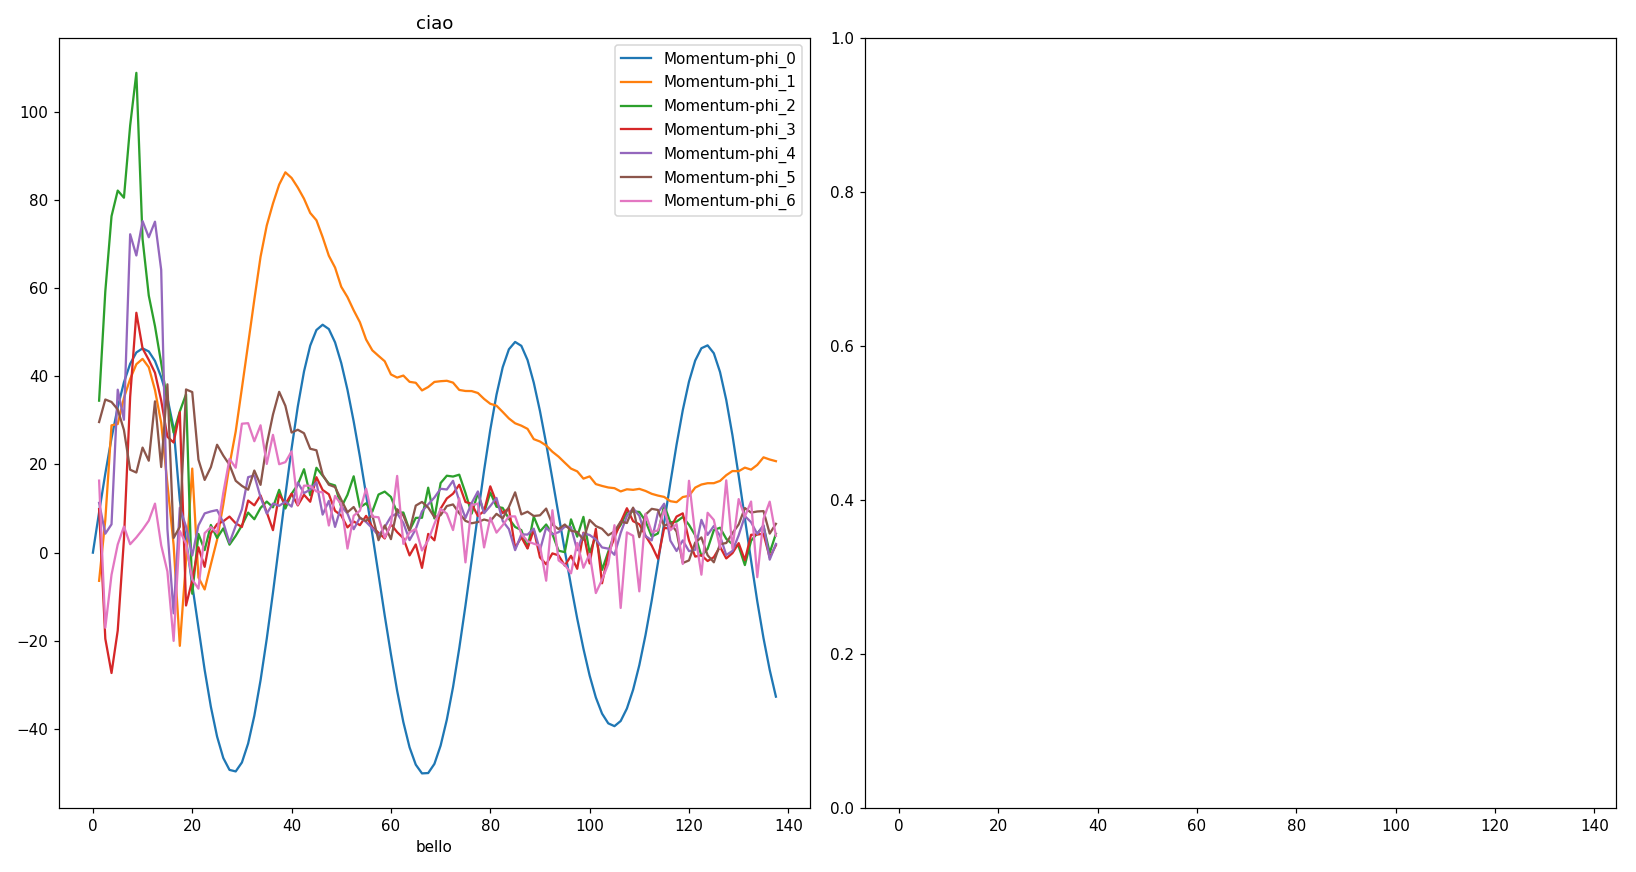

In [34]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(15,8),sharex=True)

ax0.set_title('ciao')
ax0.set_xlabel('bello')

for i in range(7):
    ciii = 'Momentum-phi_{}'.format(i)
    ax0.plot(df['fs'],df[ciii])

ax0.legend()



fig.tight_layout();

<IPython.core.display.Javascript object>


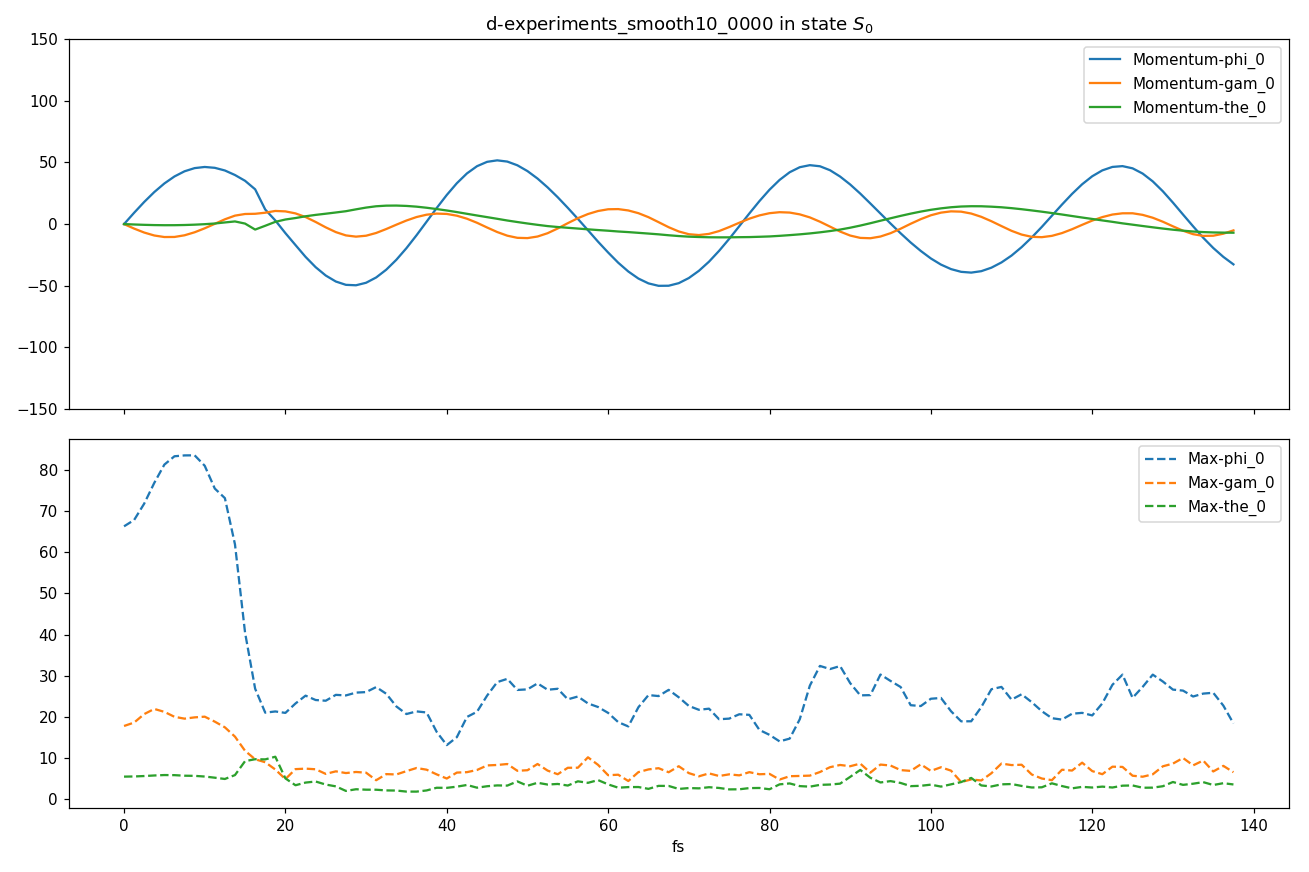

<IPython.core.display.Javascript object>


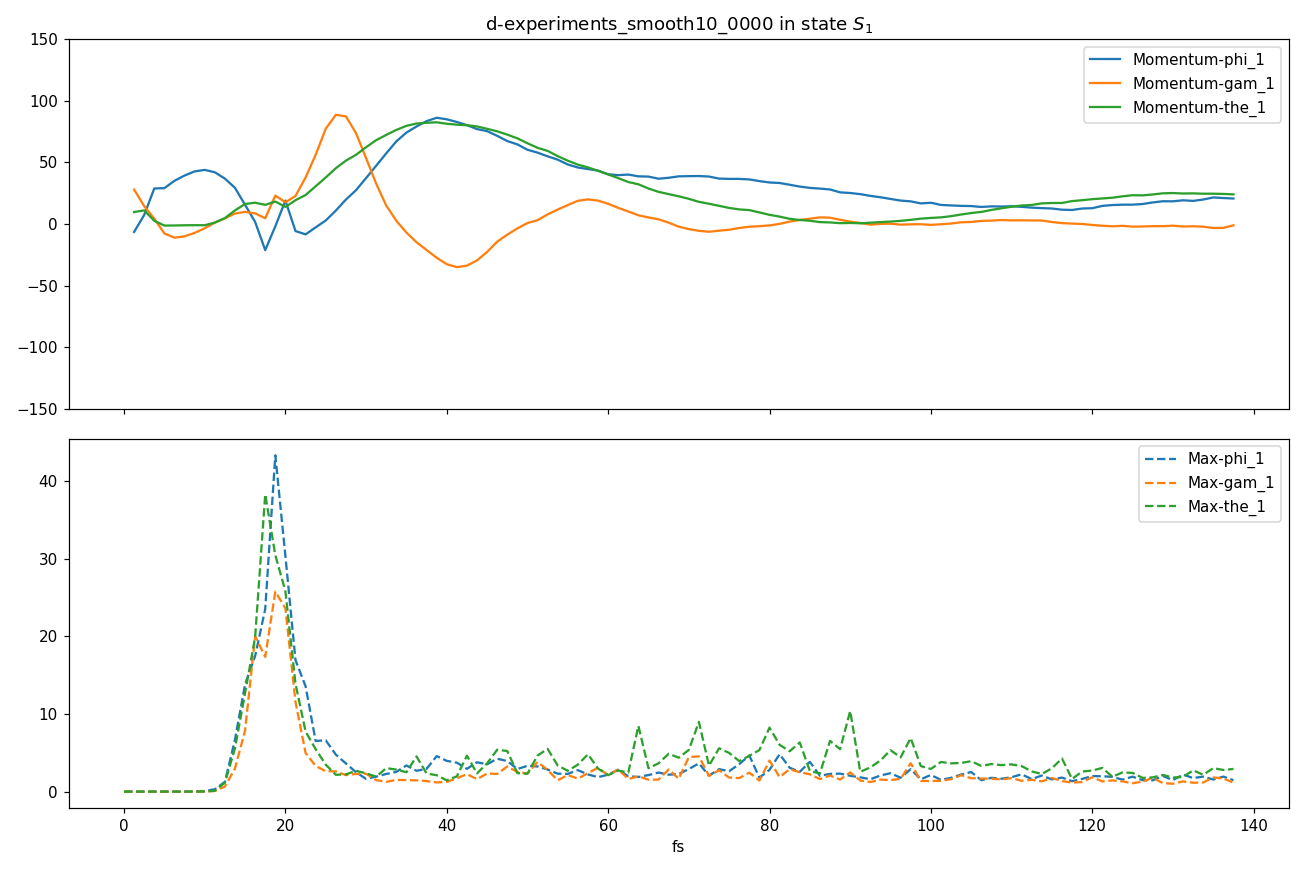

<IPython.core.display.Javascript object>


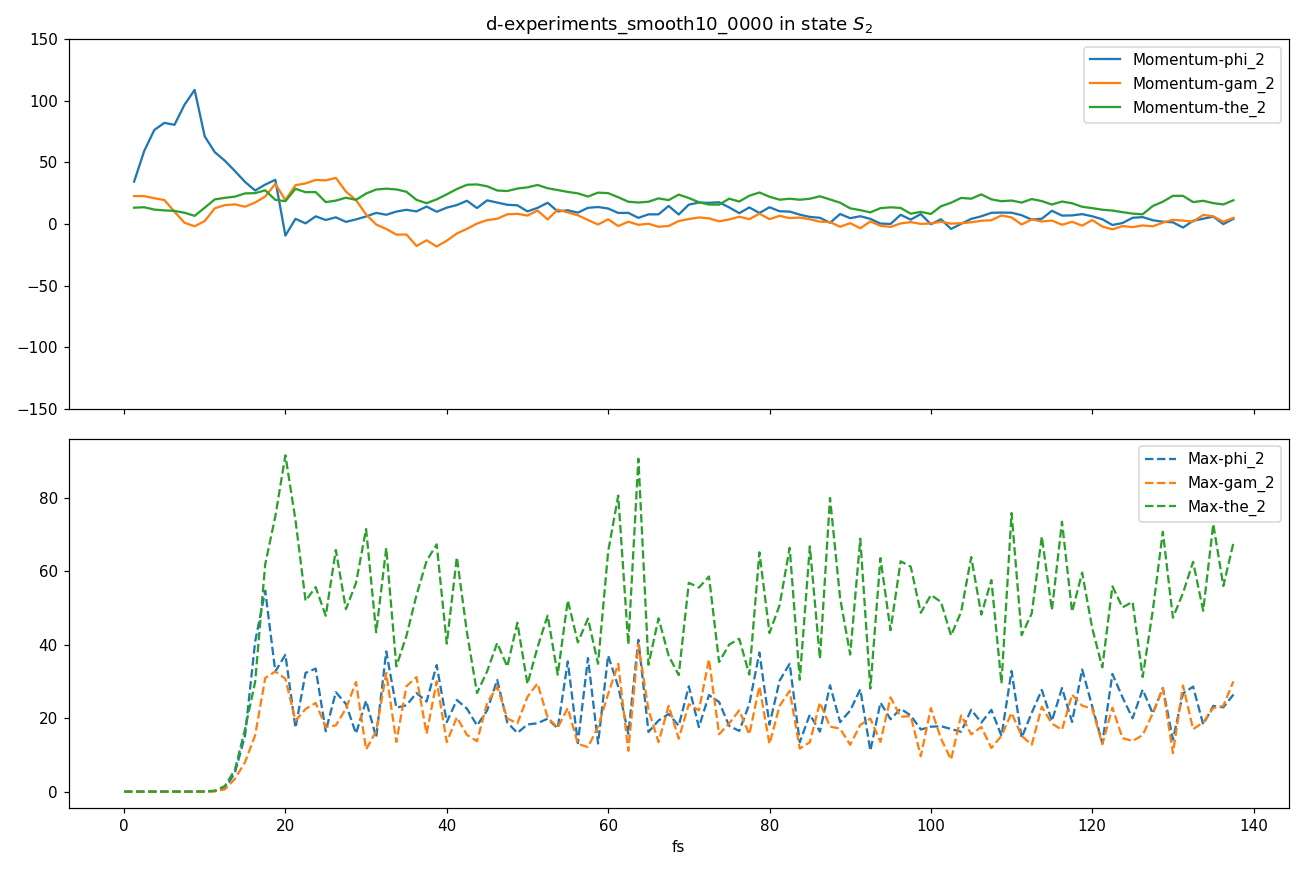

<IPython.core.display.Javascript object>


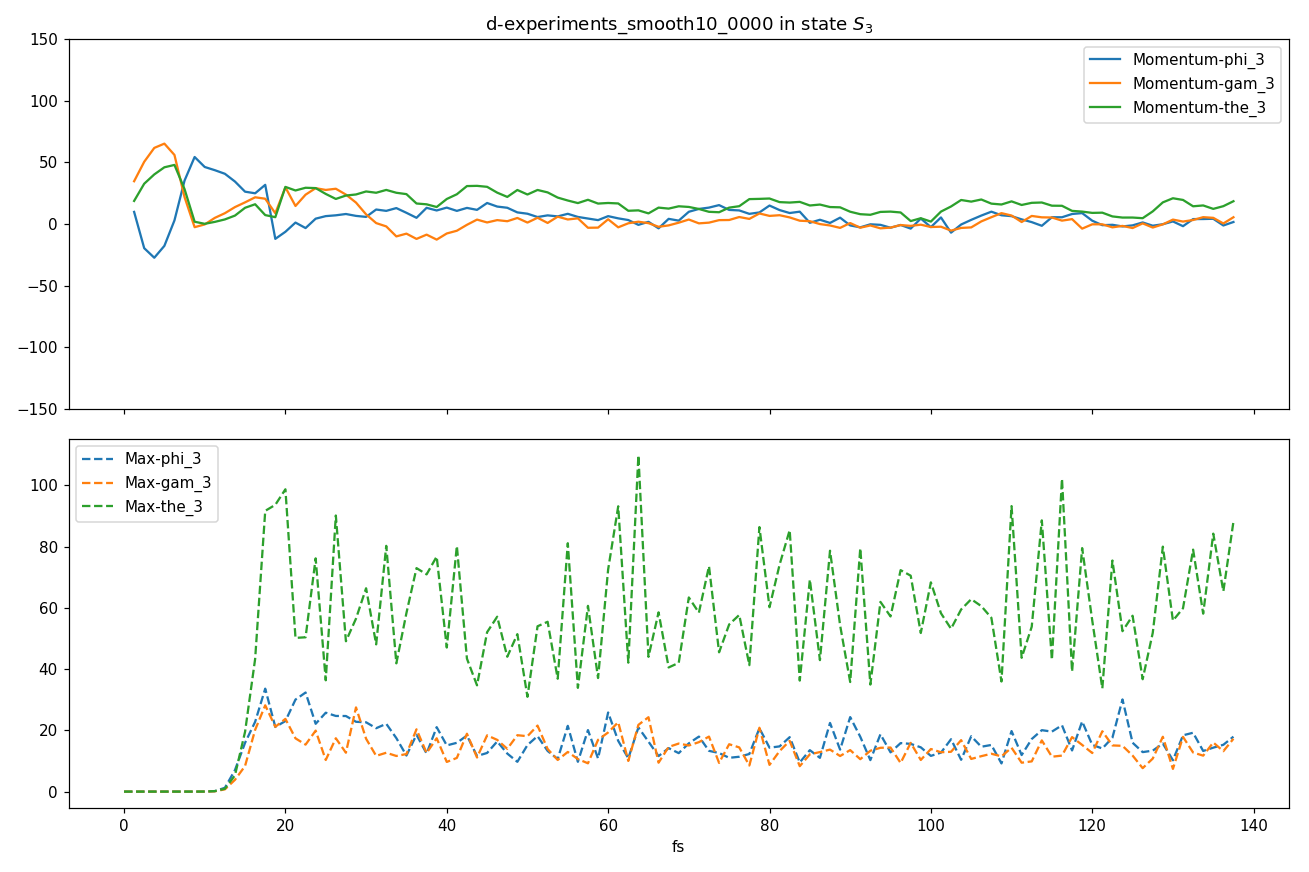

<IPython.core.display.Javascript object>


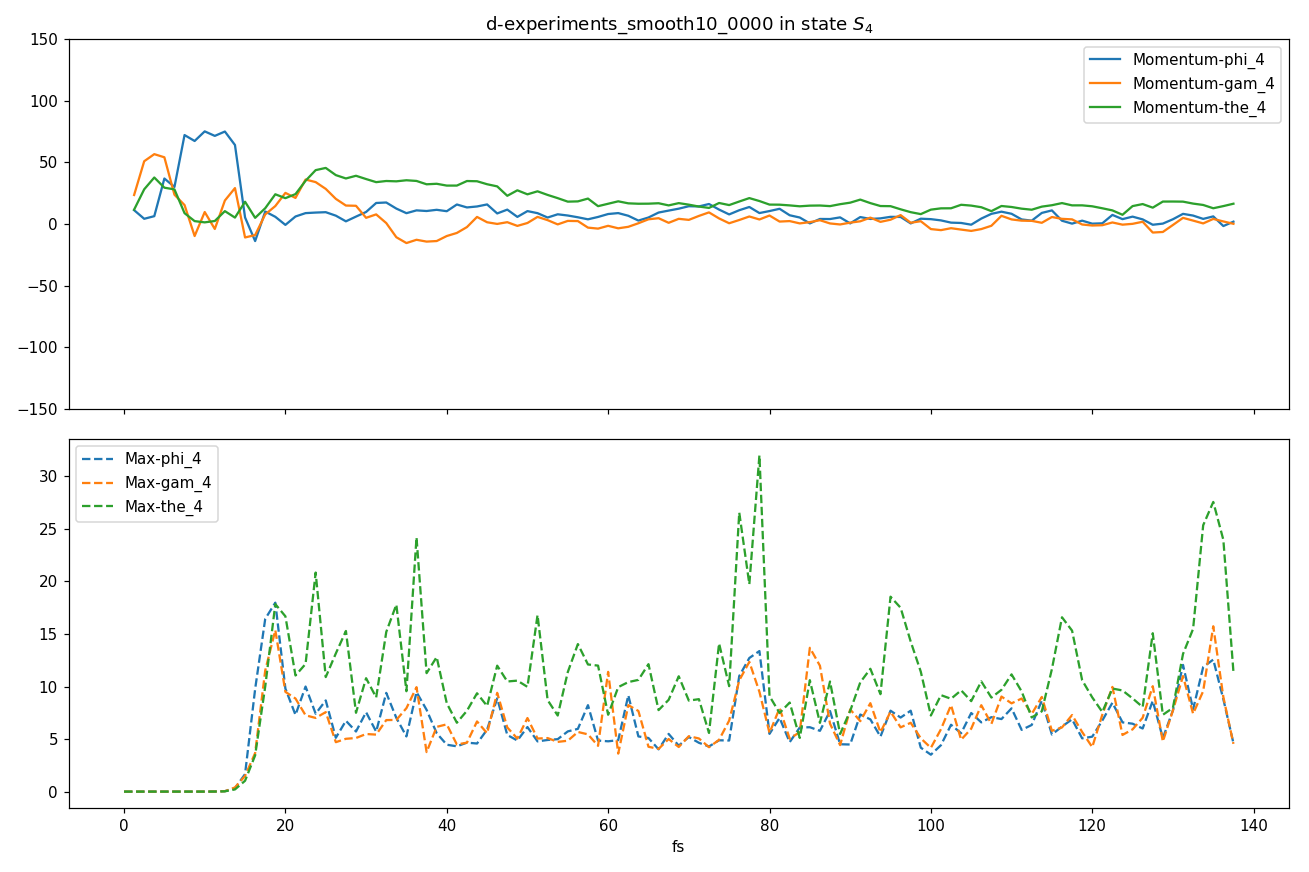

<IPython.core.display.Javascript object>


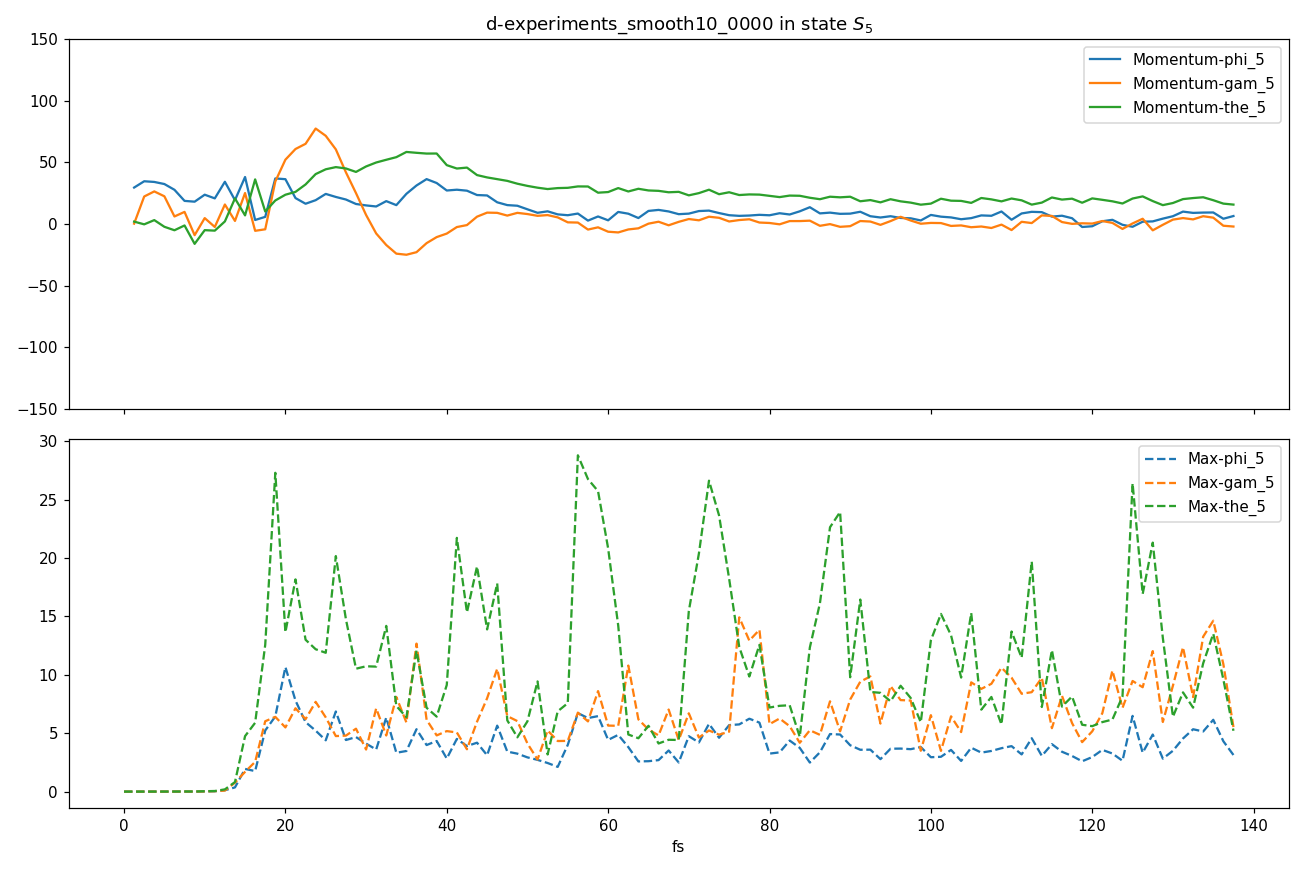

<IPython.core.display.Javascript object>


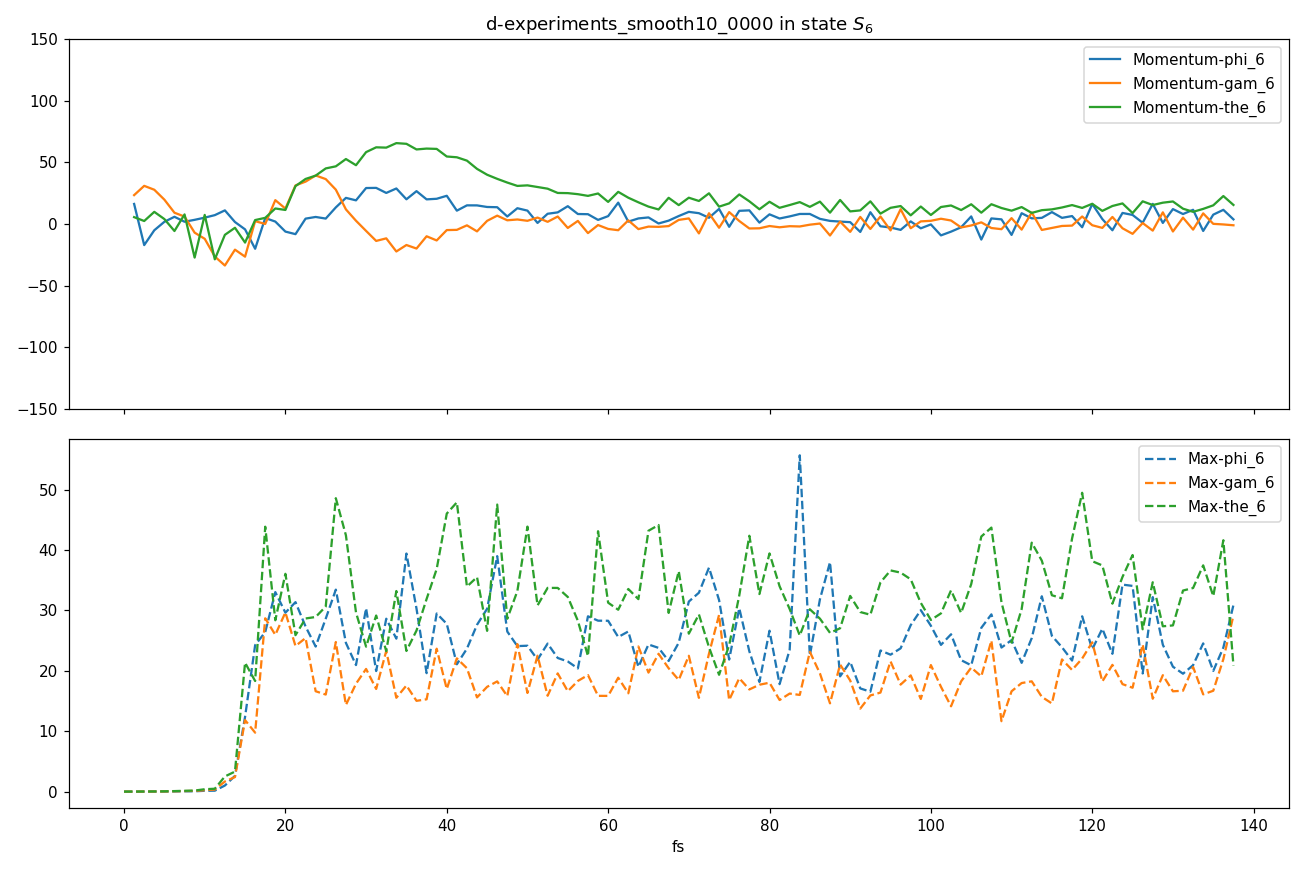

<IPython.core.display.Javascript object>


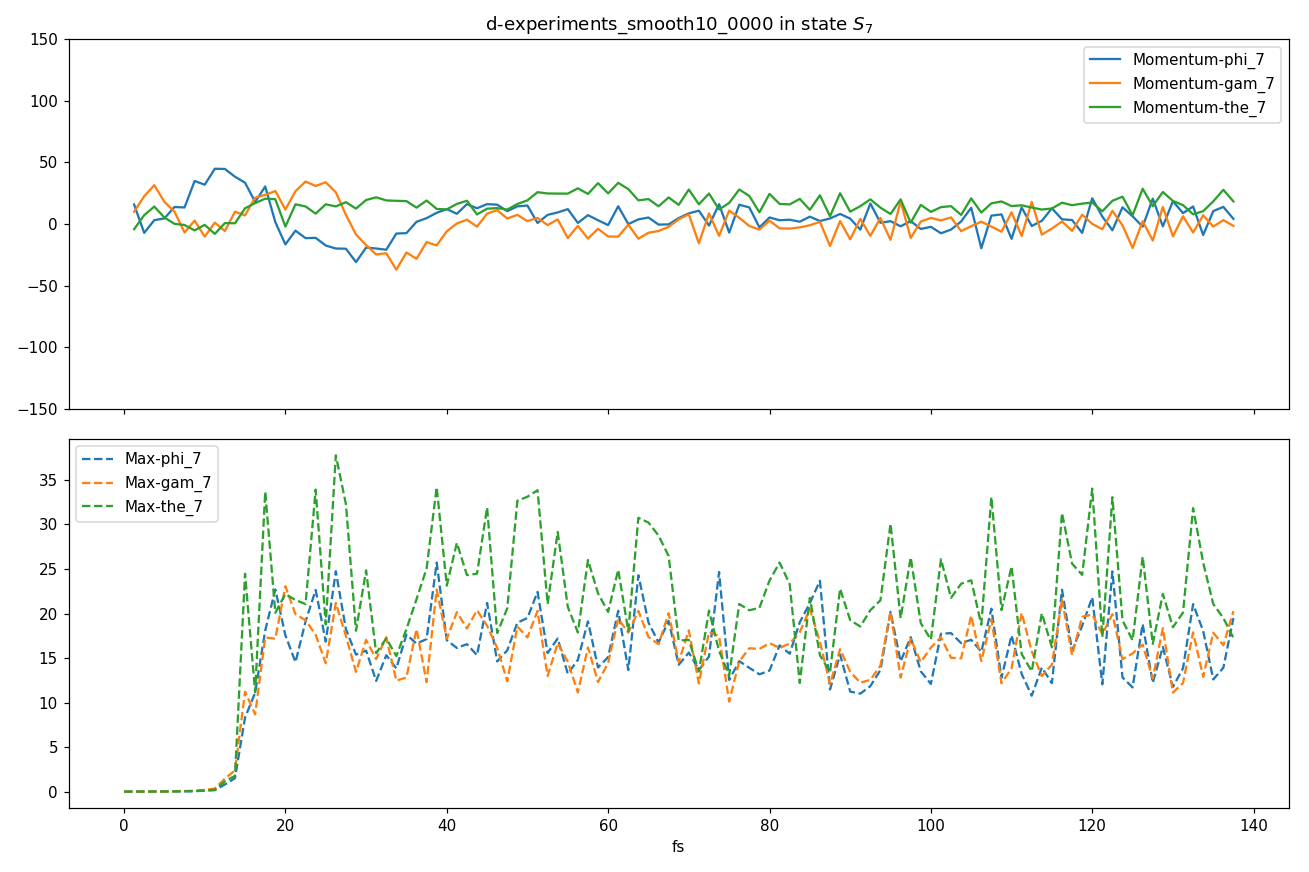

In [9]:
nstates = 8
for s in range(nstates):
    fig, [ax0,ax1] = plt.subplots(2,1,figsize=(12,8),sharex=True)

    ax0.plot(df['fs'],df['Momentum-phi_{}'.format(s)], label=('Momentum-phi_{}'.format(s)))
    ax0.plot(df['fs'],df['Momentum-gam_{}'.format(s)], label=('Momentum-gam_{}'.format(s)))
    ax0.plot(df['fs'],df['Momentum-the_{}'.format(s)], label=('Momentum-the_{}'.format(s)))
    ax0.set_title(r'{} in state $S_{}$'.format(subfolder,s))
    ax0.set_ylim(-150,150)
    ax0.legend()

    ax1.plot(df['fs'],df['Max-phi_{}'.format(s)], label=('Max-phi_{}'.format(s)),ls='--')
    ax1.plot(df['fs'],df['Max-gam_{}'.format(s)], label=('Max-gam_{}'.format(s)),ls='--')
    ax1.plot(df['fs'],df['Max-the_{}'.format(s)], label=('Max-the_{}'.format(s)),ls='--')
    ax1.set_xlabel('fs')
    ax1.legend()
    
    fig.tight_layout();
